# **Modelos de Clasificación**

In [2]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

### **Codificación de variables categóricas**

In [3]:
# Cargar el dataset
df = pd.read_csv("fraude_final.csv")  # Cambia por tu ruta real
#tamano del dataset
print("Tamaño del dataset:", df.shape)


Tamaño del dataset: (144218, 73)


In [4]:
# Seleccionar columnas tipo 'object'
categorical_cols = df.select_dtypes(include='object').columns.tolist()

print("Variables categóricas tipo object:")
print(categorical_cols)


Variables categóricas tipo object:
['id_38', 'card6']


In [5]:
# Separar X e y
X = df.drop(columns=['isfraud'])
y = df['isfraud']

# Columnas categóricas
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(exclude='object').columns.tolist()

# ColumnTransformer: aplica OneHotEncoder a categóricas, deja numéricas tal cual
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)


In [6]:
# Ajustar y transformar los datos
X_encoded = preprocessor.fit_transform(X)

# Ver el shape final
print(f"Shape original: {X.shape}")
print(f"Shape transformado: {X_encoded.shape}")


Shape original: (144218, 72)
Shape transformado: (144218, 74)


In [7]:
# Obtener nombres de columnas transformadas
columnas_encoded = preprocessor.get_feature_names_out()

# Convertir a DataFrame
df_encoded = pd.DataFrame(X_encoded, columns=columnas_encoded)

# Añadir columna objetivo
df_encoded['isfraud'] = y.values

# Guardar en CSV
#df_encoded.to_csv("fraude_train.csv", index=False)


### **Balanceo de Clases**

En *Machine Learning*, una clase se refiere a una de las categorías en las que se agrupan las observaciones dentro de un problema de clasificación. En un conjunto de datos etiquetado, cada instancia está asociada a una clase específica, permitiendo que un modelo aprenda a predecir la categoría correcta para nuevas observaciones. Cuando el número de ejemplos en cada clase está desproporcionado, se habla de un **desbalance de clases**. Esto ocurre cuando una clase tiene significativamente más ejemplos que otra(s), afectando el desempeño del modelo de clasificación. En estas situaciones, el algoritmo tiende a favorecer la clase mayoritaria, lo que puede llevar a una alta precisión global, pero con un desempeño deficiente en la clase minoritaria.

Para mitigar este problema, se emplean técnicas de balanceo de clases, cuyo objetivo es modificar la distribución de los datos o ajustar la forma en que el modelo aprende. En este estudio, se implementarán tres enfoques principales:

- **SMOTE (Synthetic Minority Over-sampling Technique)**: Es una técnica de sobremuestreo que genera nuevas instancias sintéticas de la clase minoritaria a partir de interpolaciones entre ejemplos existentes.
- **ADASYN (Adaptive Synthetic Sampling)**: Similar a SMOTE, pero con la particularidad de generar más ejemplos en aquellas regiones donde la clase minoritaria es más dispersa, mejorando la representatividad del conjunto de datos.
- **Ajuste de pesos con `class_weight='balanced'`**: Método que modifica la función de costo del modelo para penalizar más los errores en la clase minoritaria, sin necesidad de generar nuevos datos.


Distribución de clases (en %):
isfraud
0.0    92.152159
1.0     7.847841
Name: proportion, dtype: float64


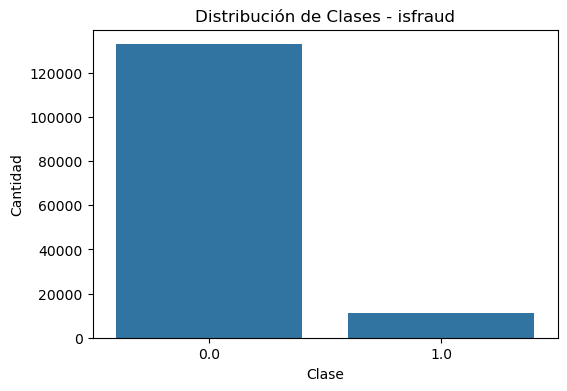

In [8]:
# Distribución de la variable objetivo
class_counts = y.value_counts(normalize=True) * 100

print("Distribución de clases (en %):")
print(class_counts)

# Gráfico
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Distribución de Clases - isfraud")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()


In [9]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE (solo a datos numéricos ya codificados)
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_encoded, y)

# Verificar resultado
import pandas as pd
print("Distribución tras SMOTE:")
print(pd.Series(y_bal).value_counts(normalize=True) * 100)


Distribución tras SMOTE:
isfraud
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64


In [10]:
# Combinar X e y en un único DataFrame
#df_bal = pd.DataFrame(X_bal)
#df_bal['isfraud'] = y_bal

# Guardar a CSV
#df_bal.to_csv("fraude_balanceado.csv", index=False)

## **Contextualización**

Para la evaluación de los modelos de clasificación, se eligió la variable ``isfraud`` como objetivo, con el fin de construir un sistema capaz de detectar transacciones electrónicas potencialmente fraudulentas. Este tipo de problemas es común en contextos reales de comercio electrónico, donde el desbalance entre transacciones legítimas y fraudulentas representa un desafío significativo para el entrenamiento efectivo de modelos de aprendizaje automático. En este proyecto, se parte de un conjunto de datos con características transaccionales diversas, como el monto de pago, atributos técnicos de la tarjeta y variables codificadas por el sistema de detección.

Dado que la clase minoritaria representa solo el 8% del total, se aplicó la técnica de sobremuestreo SMOTE para balancear el conjunto de datos y permitir una evaluación justa y efectiva de los modelos. Esta elección no solo busca mejorar el desempeño de clasificación sobre la clase positiva, sino también simular un entorno más realista donde el modelo pueda aprender patrones distintivos del fraude sin verse sesgado por la mayoría. A partir de este conjunto balanceado se entrenarán y evaluarán diferentes clasificadores.

## **Modelos BenchMark**

Ya teniendo la certeza de que las clases se encuentran balanceada, se procede entonces a ejecutar los modelos de referencia para el modelo de clasificación, en este caso ejecutaremos K-Nearest Neighbors (KNN), Clasificación de Bayes, Regresión Logística (Regularización L1/L2 - Ridge, Lasso respectivamente), Decision Tree, Random Forest, XGBoost (Lime), y Máquinas de Soporte Vectorial (SVM). Para cada caso analizaremos…

## **Implementación de los modelos (sin optimización)**

In [11]:
fraude_train = pd.read_csv("fraude_train.csv")  # Cambia por tu ruta real

### **KNN (K-Nearest Neighbors)**

In [22]:
# === 1. Importar librerías necesarias ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# === 2. Separar variables predictoras y objetivo ===
X = fraude_train.drop(columns=['isfraud'])
y = fraude_train['isfraud']

# === 3. Dividir en entrenamiento y prueba (estratificado) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === 4. Escalar los datos ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Aplicar RandomOverSampler SOLO en entrenamiento ===
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train_scaled, y_train)

# === 6. Verificar distribución balanceada ===
from collections import Counter
print("Distribución después del balanceo:", Counter(y_train_bal))


Distribución después del balanceo: Counter({0.0: 93029, 1.0: 93029})


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

# === 1. Preparar variables para guardar resultados ===
auc_scores = []
best_auc = 0
best_k = 1

# === 2. Definir validación cruzada estratificada ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(roc_auc_score, needs_proba=True)

# === 3. Iterar sobre valores de k ===
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_bal, y_train_bal, cv=cv, scoring=scorer)
    mean_auc = scores.mean()
    auc_scores.append(mean_auc)
    
    print(f"AUC promedio para k={k}: {mean_auc:.4f}")
    
    if mean_auc > best_auc:
        best_auc = mean_auc
        best_k = k

print(f"\nMejor AUC: {best_auc:.4f}, obtenido con k={best_k}")


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


AUC promedio para k=1: 0.9818
AUC promedio para k=2: 0.9818
AUC promedio para k=3: 0.9817
AUC promedio para k=4: 0.9817
AUC promedio para k=5: 0.9815
AUC promedio para k=6: 0.9811
AUC promedio para k=7: 0.9803
AUC promedio para k=8: 0.9788
AUC promedio para k=9: 0.9768
AUC promedio para k=10: 0.9745
AUC promedio para k=11: 0.9716
AUC promedio para k=12: 0.9688
AUC promedio para k=13: 0.9661
AUC promedio para k=14: 0.9636
AUC promedio para k=15: 0.9611
AUC promedio para k=16: 0.9590
AUC promedio para k=17: 0.9570
AUC promedio para k=18: 0.9551
AUC promedio para k=19: 0.9533
AUC promedio para k=20: 0.9515

Mejor AUC: 0.9818, obtenido con k=2


In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import time

# === Entrenamiento con el mejor k ===
best_k = 2
knn = KNeighborsClassifier(n_neighbors=best_k)

start_time = time.time()
knn.fit(X_train_bal, y_train_bal)
y_pred = knn.predict(X_test_scaled)
y_proba = knn.predict_proba(X_test_scaled)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Tiempo de cómputo (KNN con k={best_k}): {elapsed_time:.4f} segundos")

# === Reporte de clasificación ===
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))


Tiempo de cómputo (KNN con k=2): 14.8305 segundos

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     39871
         1.0       0.63      0.58      0.60      3395

    accuracy                           0.94     43266
   macro avg       0.80      0.77      0.79     43266
weighted avg       0.94      0.94      0.94     43266



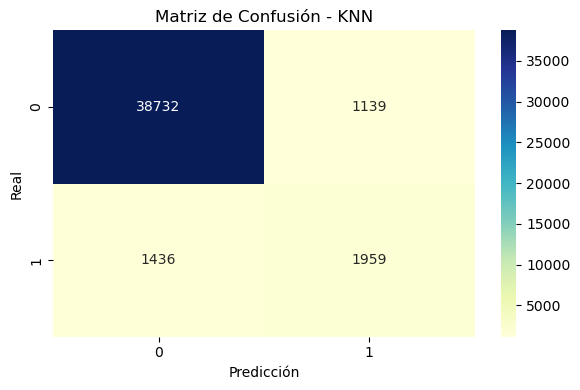

In [14]:

# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - KNN")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()



AUC final sobre test: 0.7993


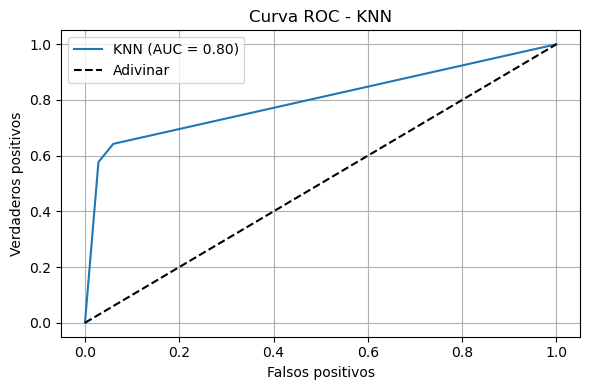

In [15]:

# === Curva ROC y AUC ===
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
auc_score = roc_auc_score(y_test, y_proba[:, 1])
print(f"\nAUC final sobre test: {auc_score:.4f}")

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'KNN (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - KNN")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


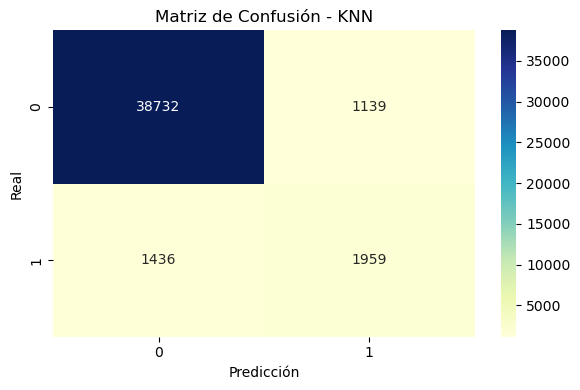

In [16]:

# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - KNN")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


Para la implementación del modelo KNN, se siguió un enfoque riguroso de preprocesamiento y validación para garantizar una evaluación honesta del rendimiento del clasificador en un contexto altamente desbalanceado. El conjunto de datos original fue dividido en entrenamiento y prueba mediante `train_test_split` estratificado, preservando la proporción original de clases. Posteriormente, se aplicó `StandardScaler` para normalizar las variables numéricas, y se utilizó la técnica `RandomOverSampler` exclusivamente sobre el conjunto de entrenamiento para balancear las clases sin generar ejemplos sintéticos. La selección del parámetro `k` óptimo se realizó mediante validación cruzada estratificada (`StratifiedKFold`) utilizando como métrica principal el AUC, debido a su idoneidad en contextos donde una de las clases es minoritaria, como es el caso del fraude.

El valor óptimo encontrado fue `k=2`, el cual arrojó un AUC promedio de 0.9818 en validación cruzada sobre datos balanceados. Al evaluar el modelo final sobre el conjunto de prueba real (no balanceado), se obtuvo un AUC de 0.7993, junto con una precisión de 0.63 y un recall de 0.58 para la clase positiva (`isfraud=1`). Estos resultados demuestran una adecuada capacidad del modelo para detectar fraudes reales sin caer en sobreajuste, dado que el conjunto de prueba se mantuvo completamente separado durante el proceso de selección y entrenamiento. La matriz de confusión y la curva ROC confirman un equilibrio aceptable entre falsos positivos y verdaderos positivos, lo que valida el desempeño del modelo en condiciones realistas.


#### **Prueba 2 con KNN (Balanceo con SMOTETomek)**

In [23]:
# === 1. Importar librerías necesarias ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# === 2. Separar variables predictoras y objetivo ===
X = fraude_train.drop(columns=['isfraud'])
y = fraude_train['isfraud']

# === 3. Dividir en entrenamiento y prueba (estratificado) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === 4. Escalar los datos ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Aplicar RandomOverSampler SOLO en entrenamiento ===
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train_scaled, y_train)

# === 6. Verificar distribución balanceada ===
from collections import Counter
print("Distribución después del balanceo:", Counter(y_train_bal))


Distribución después del balanceo: Counter({0.0: 92992, 1.0: 92992})


In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

# === 1. Preparar variables para guardar resultados ===
auc_scores = []
best_auc = 0
best_k = 1

# === 2. Definir validación cruzada estratificada ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(roc_auc_score, needs_proba=True)

# === 3. Iterar sobre valores de k ===
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_bal, y_train_bal, cv=cv, scoring=scorer)
    mean_auc = scores.mean()
    auc_scores.append(mean_auc)
    
    print(f"AUC promedio para k={k}: {mean_auc:.4f}")
    
    if mean_auc > best_auc:
        best_auc = mean_auc
        best_k = k

print(f"\nMejor AUC: {best_auc:.4f}, obtenido con k={best_k}")


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


AUC promedio para k=1: 0.9631
AUC promedio para k=2: 0.9706
AUC promedio para k=3: 0.9753
AUC promedio para k=4: 0.9784
AUC promedio para k=5: 0.9804
AUC promedio para k=6: 0.9822
AUC promedio para k=7: 0.9833
AUC promedio para k=8: 0.9843
AUC promedio para k=9: 0.9848
AUC promedio para k=10: 0.9848
AUC promedio para k=11: 0.9848
AUC promedio para k=12: 0.9844
AUC promedio para k=13: 0.9837
AUC promedio para k=14: 0.9830
AUC promedio para k=15: 0.9821
AUC promedio para k=16: 0.9813
AUC promedio para k=17: 0.9803
AUC promedio para k=18: 0.9792
AUC promedio para k=19: 0.9782
AUC promedio para k=20: 0.9771

Mejor AUC: 0.9848, obtenido con k=9


In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import time

# === Entrenamiento con el mejor k ===
best_k = 9
knn = KNeighborsClassifier(n_neighbors=best_k)

start_time = time.time()
knn.fit(X_train_bal, y_train_bal)
y_pred = knn.predict(X_test_scaled)
y_proba = knn.predict_proba(X_test_scaled)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Tiempo de cómputo (KNN con k={best_k}): {elapsed_time:.4f} segundos")

# === Reporte de clasificación ===
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))


Tiempo de cómputo (KNN con k=9): 22.7771 segundos

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.98      0.84      0.90     39871
         1.0       0.29      0.76      0.42      3395

    accuracy                           0.83     43266
   macro avg       0.63      0.80      0.66     43266
weighted avg       0.92      0.83      0.86     43266



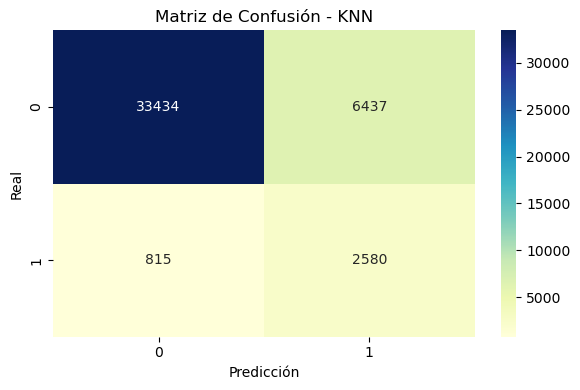

In [26]:

# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - KNN")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()



AUC final sobre test: 0.8665


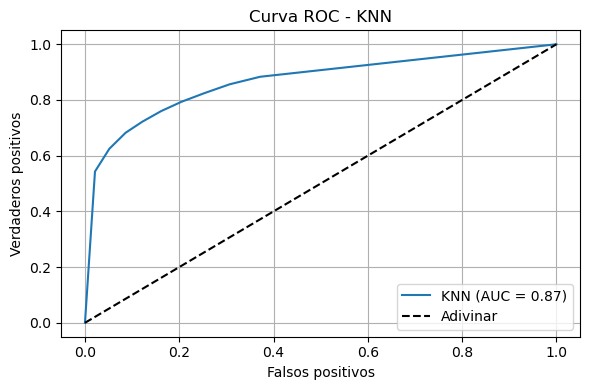

In [27]:

# === Curva ROC y AUC ===
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
auc_score = roc_auc_score(y_test, y_proba[:, 1])
print(f"\nAUC final sobre test: {auc_score:.4f}")

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'KNN (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - KNN")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


#### **Optimización del modelo con KD_tree**

In [11]:
# === 1. Importar librerías necesarias ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# === 2. Separar variables predictoras y objetivo ===
X = fraude_train.drop(columns=['isfraud'])
y = fraude_train['isfraud']

# === 3. Dividir en entrenamiento y prueba (estratificado) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === 4. Escalar los datos ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Aplicar RandomOverSampler SOLO en entrenamiento ===
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train_scaled, y_train)

# === 6. Verificar distribución balanceada ===
from collections import Counter
print("Distribución después del balanceo:", Counter(y_train_bal))


Distribución después del balanceo: Counter({0.0: 92992, 1.0: 92992})


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import time

# === Entrenamiento y evaluación con KD-Tree ===
knn_kdtree_final = KNeighborsClassifier(n_neighbors=9, algorithm='kd_tree', n_jobs=-1)

start_time = time.time()
knn_kdtree_final.fit(X_train_bal, y_train_bal)
y_pred_kdtree = knn_kdtree_final.predict(X_test_scaled)
y_proba_kdtree = knn_kdtree_final.predict_proba(X_test_scaled)[:, 1]
end_time = time.time()

elapsed_time_kdtree = end_time - start_time
print(f"Tiempo de cómputo (KNN KD-Tree con k=9): {elapsed_time_kdtree:.4f} segundos")

# === Reporte de clasificación ===
print("\n=== Classification Report (KD-Tree) ===")
print(classification_report(y_test, y_pred_kdtree, digits=4))



Tiempo de cómputo (KNN KD-Tree con k=9): 284.7541 segundos

=== Classification Report (KD-Tree) ===
              precision    recall  f1-score   support

         0.0     0.9762    0.8386    0.9022     39871
         1.0     0.2861    0.7599    0.4157      3395

    accuracy                         0.8324     43266
   macro avg     0.6312    0.7992    0.6589     43266
weighted avg     0.9221    0.8324    0.8640     43266



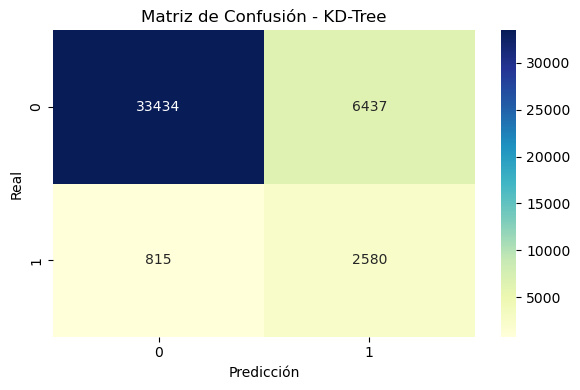

In [17]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# === Matriz de Confusión (diseño personalizado) ===
cm = confusion_matrix(y_test, y_pred_kdtree)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - KD-Tree")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()



AUC final sobre test (KD-Tree): 0.8665


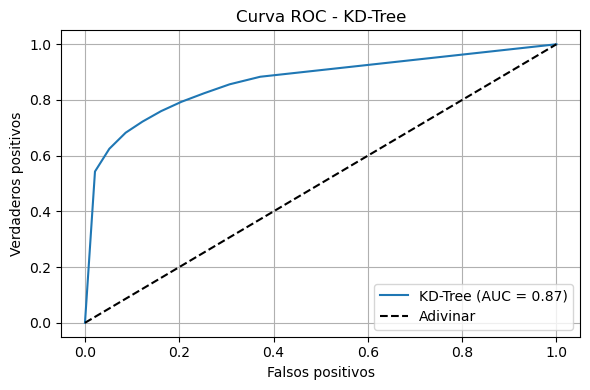

In [18]:

# === Curva ROC y AUC (diseño personalizado) ===
fpr, tpr, _ = roc_curve(y_test, y_proba_kdtree)
auc_score = roc_auc_score(y_test, y_proba_kdtree)
print(f"\nAUC final sobre test (KD-Tree): {auc_score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'KD-Tree (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - KD-Tree")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from time import time
import matplotlib.pyplot as plt

# Entradas: X, y ya preprocesados
# X_train, X_test, y_train, y_test deben estar definidos

# KNN base (sin optimización)
knn_base = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=9, algorithm='auto'))  # algoritmo automático
])

# KNN con KD-Tree
knn_kdtree = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=9, algorithm='kd_tree'))  # algoritmo forzado a KD-Tree
])

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Medir tiempos y AUC
def evaluar_modelo(modelo, nombre):
    inicio = time()
    auc_scores = cross_val_score(modelo, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    fin = time()
    print(f"{nombre} - Tiempo: {fin - inicio:.4f} segundos - AUC promedio: {auc_scores.mean():.4f}")
    return auc_scores.mean(), fin - inicio

auc_base, tiempo_base = evaluar_modelo(knn_base, "KNN (auto)")
auc_kdtree, tiempo_kdtree = evaluar_modelo(knn_kdtree, "KNN (KD-Tree)")


KNN (auto) - Tiempo: 11.8285 segundos - AUC promedio: 0.8402
KNN (KD-Tree) - Tiempo: 201.6385 segundos - AUC promedio: 0.8402


#### **Optimización del modelo con Ball_trees**

In [20]:
# === 1. Importar librerías necesarias ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# === 2. Separar variables predictoras y objetivo ===
X = fraude_train.drop(columns=['isfraud'])
y = fraude_train['isfraud']

# === 3. Dividir en entrenamiento y prueba (estratificado) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === 4. Escalar los datos ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Aplicar RandomOverSampler SOLO en entrenamiento ===
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train_scaled, y_train)

# === 6. Verificar distribución balanceada ===
from collections import Counter
print("Distribución después del balanceo:", Counter(y_train_bal))


Distribución después del balanceo: Counter({0.0: 92992, 1.0: 92992})


In [22]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import time

# === Entrenamiento y evaluación con Ball Tree ===
knn_balltree = KNeighborsClassifier(n_neighbors=9, algorithm='ball_tree', n_jobs=-1)

start_time = time.time()
knn_balltree.fit(X_train_bal, y_train_bal)
y_pred_balltree = knn_balltree.predict(X_test_scaled)
y_proba_balltree = knn_balltree.predict_proba(X_test_scaled)[:, 1]
end_time = time.time()

elapsed_time_balltree = end_time - start_time
print(f"Tiempo de cómputo (KNN Ball Tree con k=9): {elapsed_time_balltree:.4f} segundos")

# === Reporte de clasificación ===
print("\n=== Classification Report (Ball Tree) ===")
print(classification_report(y_test, y_pred_balltree, digits=4))



Tiempo de cómputo (KNN Ball Tree con k=9): 376.8188 segundos

=== Classification Report (Ball Tree) ===
              precision    recall  f1-score   support

         0.0     0.9762    0.8386    0.9022     39871
         1.0     0.2861    0.7599    0.4157      3395

    accuracy                         0.8324     43266
   macro avg     0.6312    0.7992    0.6589     43266
weighted avg     0.9221    0.8324    0.8640     43266



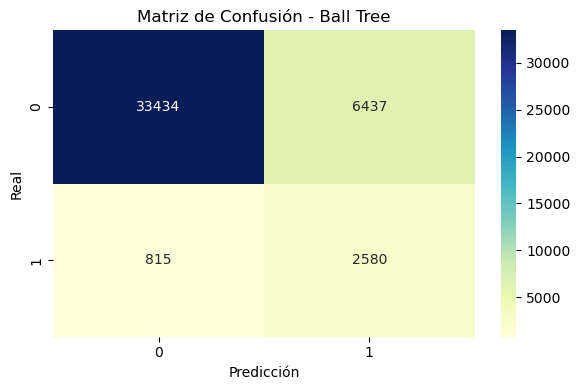

In [23]:
# === Matriz de Confusión (Ball Tree) ===
cm = confusion_matrix(y_test, y_pred_balltree)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - Ball Tree")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()



AUC final sobre test (Ball Tree): 0.8665


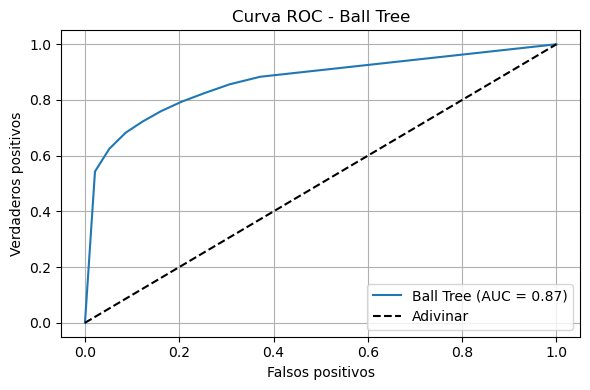

In [24]:
# === Curva ROC y AUC (Ball Tree) ===
fpr, tpr, _ = roc_curve(y_test, y_proba_balltree)
auc_score = roc_auc_score(y_test, y_proba_balltree)
print(f"\nAUC final sobre test (Ball Tree): {auc_score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Ball Tree (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - Ball Tree")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


#### **Optimización del modelo con FAISS**

In [25]:
# === 1. Importar librerías necesarias ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# === 2. Separar variables predictoras y objetivo ===
X = fraude_train.drop(columns=['isfraud'])
y = fraude_train['isfraud']

# === 3. Dividir en entrenamiento y prueba (estratificado) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === 4. Escalar los datos ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Aplicar RandomOverSampler SOLO en entrenamiento ===
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train_scaled, y_train)

# === 6. Verificar distribución balanceada ===
from collections import Counter
print("Distribución después del balanceo:", Counter(y_train_bal))


Distribución después del balanceo: Counter({0.0: 92992, 1.0: 92992})


In [29]:
X_train_bal.dtype

dtype('float64')

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import faiss
import numpy as np
import time

# === Preparar datos (float32 para FAISS) ===
X_train_faiss = X_train_bal.astype('float32')
X_test_faiss = X_test_scaled.astype('float32')
y_train_faiss = y_train_bal.values

# === Entrenamiento y búsqueda con FAISS ===
k = 9
index = faiss.IndexFlatL2(X_train_faiss.shape[1])  # índice L2 (exacto)
index.add(X_train_faiss)

start_time = time.time()
distances, indices = index.search(X_test_faiss, k)
end_time = time.time()
elapsed_time_faiss = end_time - start_time

# === Predicciones ===
neighbors_labels = y_train_faiss[indices].astype(int)
y_pred_faiss = np.array([np.bincount(row).argmax() for row in neighbors_labels])
y_proba_faiss = np.array([row.mean() for row in neighbors_labels])

print(f"Tiempo de cómputo (KNN FAISS con k=9): {elapsed_time_faiss:.4f} segundos")

# === Reporte de clasificación ===
print("\n=== Classification Report (FAISS) ===")
print(classification_report(y_test, y_pred_faiss, digits=4))


Tiempo de cómputo (KNN FAISS con k=9): 7.2475 segundos

=== Classification Report (FAISS) ===
              precision    recall  f1-score   support

         0.0     0.9762    0.8386    0.9022     39871
         1.0     0.2861    0.7599    0.4157      3395

    accuracy                         0.8324     43266
   macro avg     0.6312    0.7992    0.6589     43266
weighted avg     0.9221    0.8324    0.8640     43266



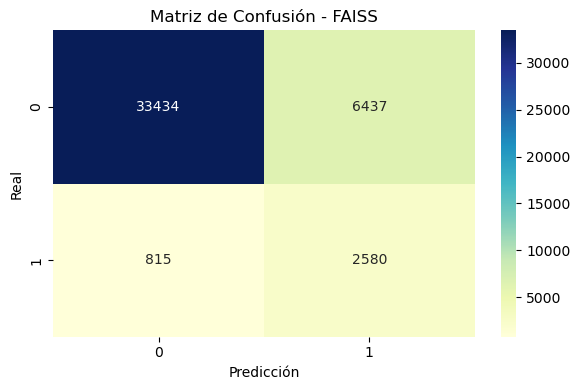

In [31]:
# === Matriz de Confusión (FAISS) ===
cm = confusion_matrix(y_test, y_pred_faiss)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - FAISS")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()



AUC final sobre test (FAISS): 0.8665


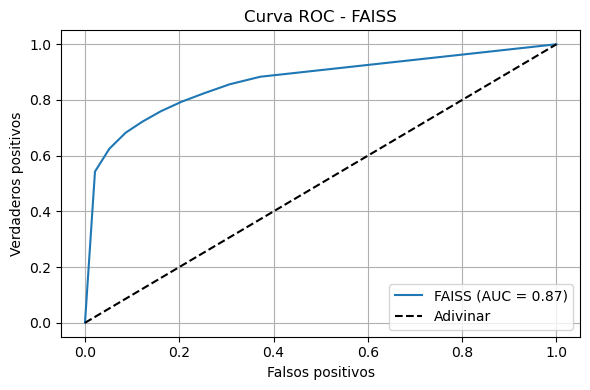

In [32]:
# === Curva ROC y AUC (FAISS) ===
fpr, tpr, _ = roc_curve(y_test, y_proba_faiss)
auc_score = roc_auc_score(y_test, y_proba_faiss)
print(f"\nAUC final sobre test (FAISS): {auc_score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'FAISS (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - FAISS")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



### **Bayes**

In [43]:
# Importar librerías necesarias 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Separar variables predictoras y objetivo
X = fraude_train.drop(columns=['isfraud'])
y = fraude_train['isfraud']

# Dividir en entrenamiento y prueba (estratificado) 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Escalar los datos 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar RandomOverSampler SOLO en entrenamient
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train_scaled, y_train)

# Verificar distribución balanceada 
from collections import Counter
print("Distribución después del balanceo:", Counter(y_train_bal))

Distribución después del balanceo: Counter({0.0: 92992, 1.0: 92992})


In [48]:
# === Entrenar modelo GaussianNB ===
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
import time

# Definir modelo
nb_model = GaussianNB()

# Entrenamiento y predicción
start_time = time.time()
nb_model.fit(X_train_bal, y_train_bal)
y_pred = nb_model.predict(X_test_scaled)
y_proba = nb_model.predict_proba(X_test_scaled)[:, 1]
end_time = time.time()

# Tiempo de cómputo
print(f"\nTiempo de cómputo (Naive Bayes): {end_time - start_time:.4f} segundos")

# Reporte de clasificación
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))



Tiempo de cómputo (Naive Bayes): 0.2697 segundos

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.97      0.22      0.36     39871
         1.0       0.09      0.91      0.17      3395

    accuracy                           0.28     43266
   macro avg       0.53      0.57      0.26     43266
weighted avg       0.90      0.28      0.35     43266



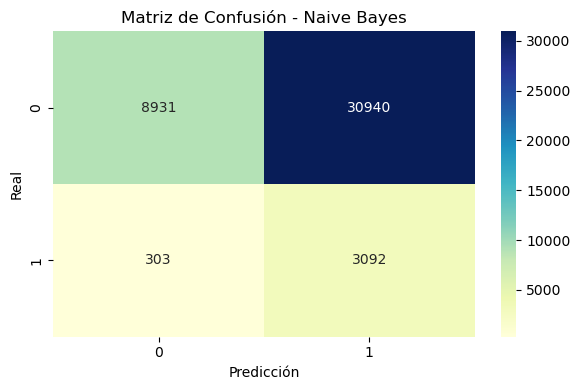

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - Naive Bayes")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()



AUC final sobre test: 0.7285


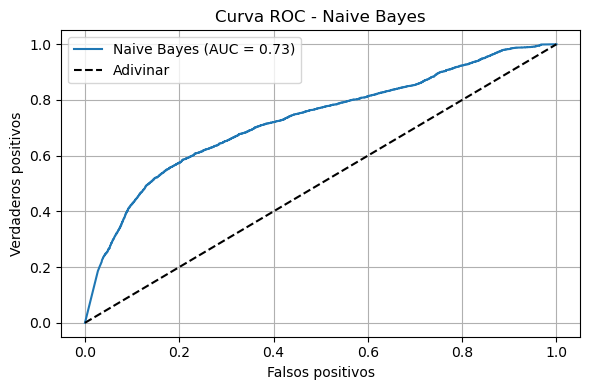

In [56]:
from sklearn.metrics import roc_curve, roc_auc_score

# === Curva ROC y AUC ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
print(f"\nAUC final sobre test: {auc_score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Naive Bayes (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - Naive Bayes")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [49]:
# === 1. Importar librerías necesarias ===
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score

# === 2. Definir grilla de valores para var_smoothing ===
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# === 3. Validación cruzada y métrica ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(roc_auc_score, needs_proba=True)

# === 4. Modelo base y búsqueda ===
nb_model = GaussianNB()
grid_search_nb = GridSearchCV(
    estimator=nb_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# === 5. Entrenar búsqueda ===
grid_search_nb.fit(X_train_bal, y_train_bal)

# === 6. Resultados ===
print("Mejor var_smoothing:", grid_search_nb.best_params_)
print("Mejor AUC promedio en validación cruzada:", grid_search_nb.best_score_)


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejor var_smoothing: {'var_smoothing': 1e-05}
Mejor AUC promedio en validación cruzada: 0.7598089016966082


In [50]:
# === Evaluación final con el mejor modelo ===
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Obtener mejor modelo
best_nb_model = grid_search_nb.best_estimator_

# Entrenamiento y predicción
start_time = time.time()
best_nb_model.fit(X_train_bal, y_train_bal)
y_pred = best_nb_model.predict(X_test_scaled)
y_proba = best_nb_model.predict_proba(X_test_scaled)[:, 1]
end_time = time.time()

# Tiempo de cómputo
print(f"\nTiempo de cómputo (Naive Bayes optimizado): {end_time - start_time:.4f} segundos")

# === Reporte de clasificación ===
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))



Tiempo de cómputo (Naive Bayes optimizado): 0.2380 segundos

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.97      0.22      0.36     39871
         1.0       0.09      0.91      0.17      3395

    accuracy                           0.28     43266
   macro avg       0.53      0.57      0.26     43266
weighted avg       0.90      0.28      0.35     43266



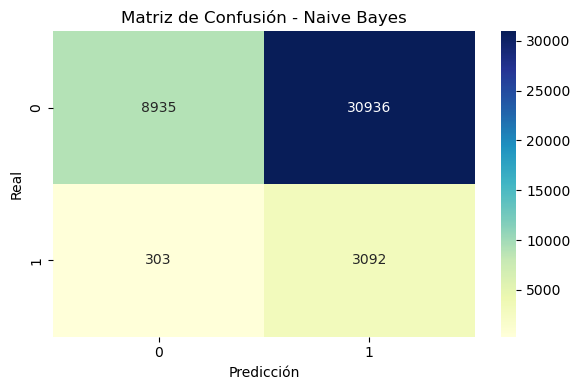

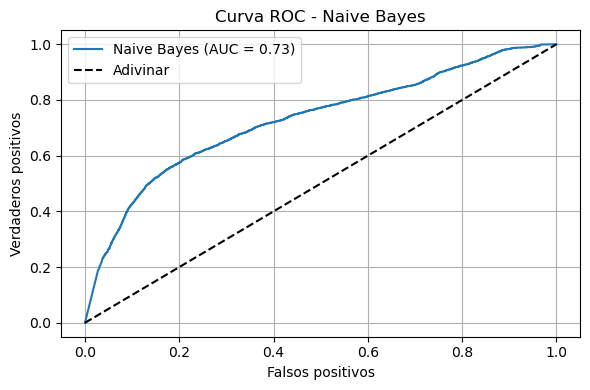

In [51]:

# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - Naive Bayes")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# === Curva ROC ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"Naive Bayes (AUC = {auc_score:.2f})")
plt.plot([0,1], [0,1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - Naive Bayes")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


#### **Optimización del modelo con `partial_fit()`**

In [52]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
import numpy as np
import time

# === Entrenamiento por lotes con partial_fit ===
nb_model = GaussianNB()
classes = np.unique(y_train_bal)

batch_size = 10000
start_time = time.time()

for i in range(0, len(X_train_bal), batch_size):
    X_batch = X_train_bal[i:i + batch_size]
    y_batch = y_train_bal[i:i + batch_size]
    nb_model.partial_fit(X_batch, y_batch, classes=classes)

end_time = time.time()

# === Predicción y reporte ===
y_pred = nb_model.predict(X_test_scaled)
y_proba = nb_model.predict_proba(X_test_scaled)[:, 1]

print(f"\nTiempo de cómputo (Naive Bayes por lotes): {end_time - start_time:.4f} segundos")
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))



Tiempo de cómputo (Naive Bayes por lotes): 0.1449 segundos

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.97      0.22      0.36     39871
         1.0       0.09      0.91      0.17      3395

    accuracy                           0.28     43266
   macro avg       0.53      0.57      0.26     43266
weighted avg       0.90      0.28      0.35     43266



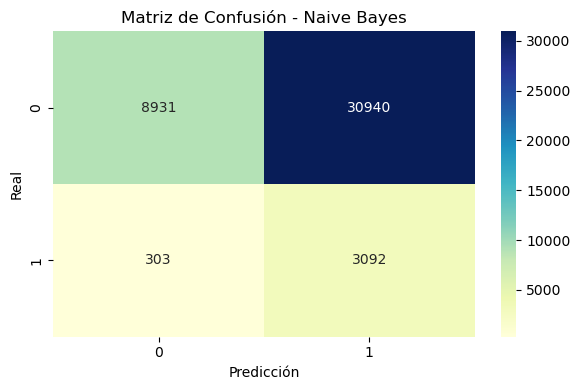

In [53]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - Naive Bayes")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


AUC final sobre test: 0.7285


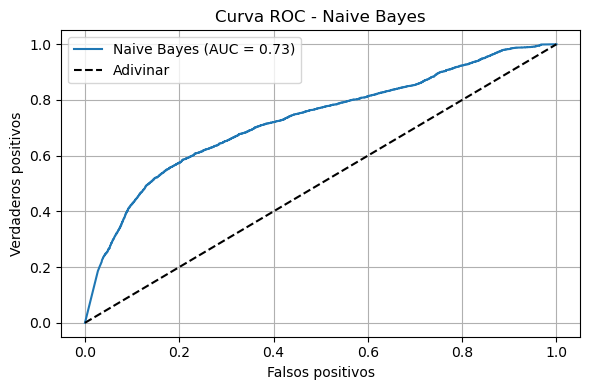

In [54]:

# === Curva ROC ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC final sobre test: {auc_score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Naive Bayes (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - Naive Bayes")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### **Ridge**

In [19]:
# Importar librerías necesarias 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Separar variables predictoras y objetivo
X = fraude_train.drop(columns=['isfraud'])
y = fraude_train['isfraud']

# Dividir en entrenamiento y prueba (estratificado) 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Escalar los datos 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar RandomOverSampler SOLO en entrenamient
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train_scaled, y_train)

# Verificar distribución balanceada 
from collections import Counter
print("Distribución después del balanceo:", Counter(y_train_bal))

Distribución después del balanceo: Counter({0.0: 92992, 1.0: 92992})


In [ ]:
# === 1. Importar librerías ===
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score

# === 2. Validación cruzada estratificada ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 3. Métrica AUC ===
scorer = make_scorer(roc_auc_score, response_method="predict_proba")

# === 4. Modelo base Ridge (penalización L2) ===
ridge_model = LogisticRegression(
    penalty='l2',
    solver='liblinear',  
    max_iter=1000,
    random_state=42
)

# === 5. Grilla de hiperparámetros (explorada en escala logarítmica) ===
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

# === 6. Configurar GridSearchCV para Ridge ===
grid_search_ridge = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# === 7. Ejecutar búsqueda en datos balanceados ===
grid_search_ridge.fit(X_train_bal, y_train_bal)

# === 8. Mostrar mejores parámetros y AUC ===
print("Mejor C:", grid_search_ridge.best_params_)
print("Mejor AUC promedio en validación cruzada:", grid_search_ridge.best_score_)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Mejor C: {'C': 100}
Mejor AUC promedio en validación cruzada: 0.8422707258126982


In [27]:
# === Entrenamiento final con mejor modelo Ridge ===
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import time

best_ridge_model = grid_search_ridge.best_estimator_

start_time = time.time()
best_ridge_model.fit(X_train_bal, y_train_bal)
y_pred = best_ridge_model.predict(X_test_scaled)
y_proba = best_ridge_model.decision_function(X_test_scaled)
end_time = time.time()

print(f"\nTiempo de cómputo (Ridge): {end_time - start_time:.4f} segundos")

# === Reporte de clasificación ===
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))



Tiempo de cómputo (Ridge): 5.4577 segundos

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.97      0.81      0.88     39871
         1.0       0.24      0.70      0.36      3395

    accuracy                           0.80     43266
   macro avg       0.60      0.76      0.62     43266
weighted avg       0.91      0.80      0.84     43266



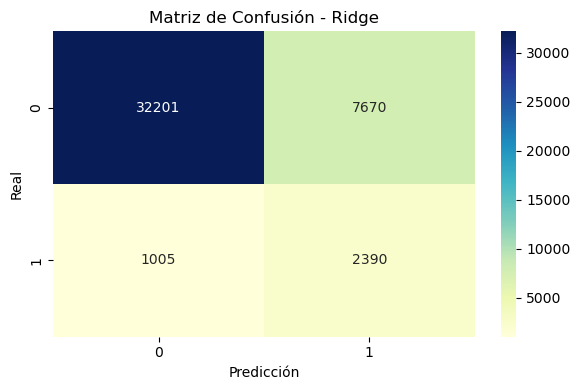

In [29]:
# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - Ridge")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


AUC final sobre test: 0.8317


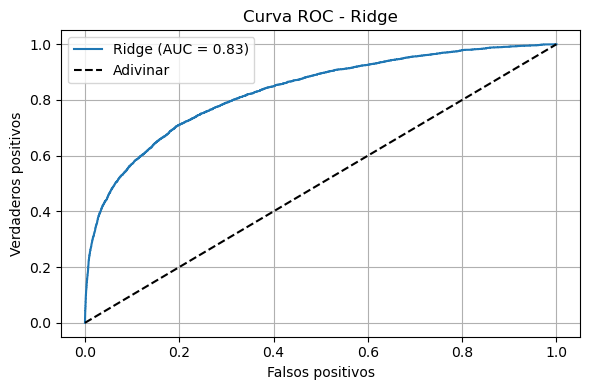

In [30]:

# === Curva ROC y AUC ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC final sobre test: {auc_score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Ridge (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - Ridge")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


#### **Optimización del modelo con Saga**

In [33]:
# Importar librerías necesarias 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Separar variables predictoras y objetivo
X = fraude_train.drop(columns=['isfraud'])
y = fraude_train['isfraud']

# Dividir en entrenamiento y prueba (estratificado) 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Escalar los datos 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar RandomOverSampler SOLO en entrenamient
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train_scaled, y_train)

# Verificar distribución balanceada 
from collections import Counter
print("Distribución después del balanceo:", Counter(y_train_bal))

Distribución después del balanceo: Counter({0.0: 92992, 1.0: 92992})


In [34]:
# === 1. Importar librerías ===
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score

# === 2. Validación cruzada estratificada ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 3. Métrica AUC ===
scorer = make_scorer(roc_auc_score, response_method="predict_proba")

# === 4. Modelo base Ridge (penalización L2) ===
ridge_model = LogisticRegression(
    penalty='l2',
    solver='saga',
    max_iter=1000,
    random_state=42
)

# === 5. Grilla de hiperparámetros (explorada en escala logarítmica) ===
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

# === 6. Configurar GridSearchCV para Ridge ===
grid_search_ridge = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# === 7. Ejecutar búsqueda en datos balanceados ===
grid_search_ridge.fit(X_train_bal, y_train_bal)

# === 8. Mostrar mejores parámetros y AUC ===
print("Mejor C:", grid_search_ridge.best_params_)
print("Mejor AUC promedio en validación cruzada:", grid_search_ridge.best_score_)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Mejor C: {'C': 100}
Mejor AUC promedio en validación cruzada: 0.8422471192196103


In [35]:
# === Entrenamiento final con mejor modelo Ridge ===
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import time

best_ridge_model = grid_search_ridge.best_estimator_

start_time = time.time()
best_ridge_model.fit(X_train_bal, y_train_bal)
y_pred = best_ridge_model.predict(X_test_scaled)
y_proba = best_ridge_model.decision_function(X_test_scaled)
end_time = time.time()

print(f"\nTiempo de cómputo (Ridge): {end_time - start_time:.4f} segundos")

# === Reporte de clasificación ===
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))


Tiempo de cómputo (Ridge): 203.4371 segundos

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.97      0.81      0.88     39871
         1.0       0.24      0.70      0.36      3395

    accuracy                           0.80     43266
   macro avg       0.60      0.76      0.62     43266
weighted avg       0.91      0.80      0.84     43266



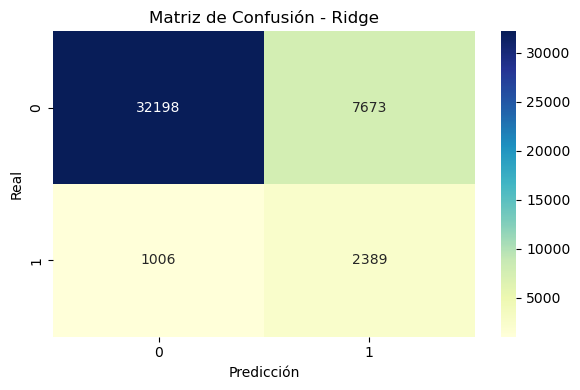

In [36]:
# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - Ridge")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


AUC final sobre test: 0.8318


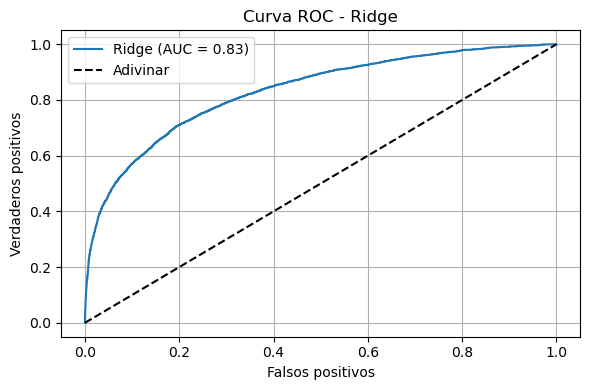

In [37]:
# === Curva ROC y AUC ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC final sobre test: {auc_score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Ridge (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - Ridge")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### **Lasso**

In [31]:
# Importar librerías necesarias 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Separar variables predictoras y objetivo
X = fraude_train.drop(columns=['isfraud'])
y = fraude_train['isfraud']

# Dividir en entrenamiento y prueba (estratificado) 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Escalar los datos 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar RandomOverSampler SOLO en entrenamient
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train_scaled, y_train)

# Verificar distribución balanceada 
from collections import Counter
print("Distribución después del balanceo:", Counter(y_train_bal))

Distribución después del balanceo: Counter({0.0: 92992, 1.0: 92992})


In [36]:
# === 1. Importar librerías necesarias ===
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score

# === 2. Validación cruzada estratificada ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 3. Métrica: AUC ===
scorer = make_scorer(roc_auc_score, response_method="predict_proba")

# === 4. Modelo base Lasso (penalización L1) ===
lasso_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    random_state=42
)
# === 5. Grilla de hiperparámetros (explorada en escala logarítmica) ===
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

# === 6. Configurar GridSearchCV para Lasso ===
grid_search_lasso = GridSearchCV(
    estimator=lasso_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)
# === 7. Entrenamiento con búsqueda de hiperparámetros ===
grid_search_lasso.fit(X_train_bal, y_train_bal)

# === 8. Mostrar mejores parámetros y AUC ===
print("Mejor C:", grid_search_lasso.best_params_)
print("Mejor AUC promedio en validación cruzada:", grid_search_lasso.best_score_)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Mejor C: {'C': 100}
Mejor AUC promedio en validación cruzada: 0.8422636405338263


In [37]:
# === Entrenamiento final con mejor modelo Lasso ===
best_lasso_model = grid_search_lasso.best_estimator_

import time
start_time = time.time()
best_lasso_model.fit(X_train_bal, y_train_bal)
y_pred = best_lasso_model.predict(X_test_scaled)
y_proba = best_lasso_model.predict_proba(X_test_scaled)[:, 1]
end_time = time.time()

print(f"\nTiempo de cómputo (Lasso): {end_time - start_time:.4f} segundos")

# === Reporte de clasificación ===
from sklearn.metrics import classification_report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))



Tiempo de cómputo (Lasso): 6.4341 segundos

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.97      0.81      0.88     39871
         1.0       0.24      0.70      0.36      3395

    accuracy                           0.80     43266
   macro avg       0.60      0.76      0.62     43266
weighted avg       0.91      0.80      0.84     43266



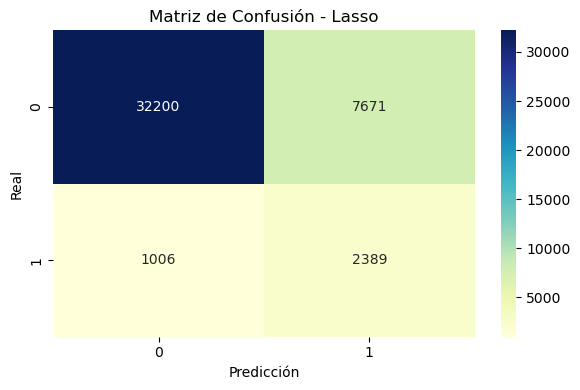

In [41]:
# === Matriz de confusión ===
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - Lasso")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


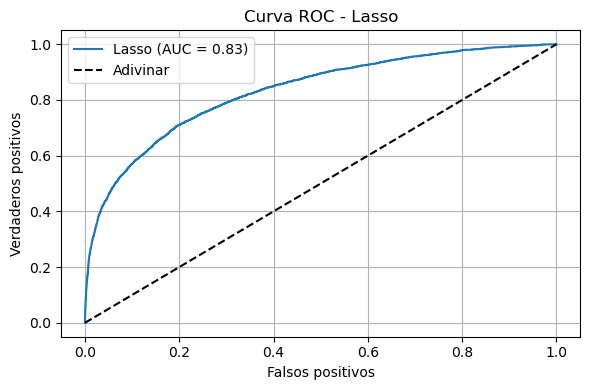

In [42]:
# === Curva ROC y AUC ===
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Lasso (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - Lasso")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

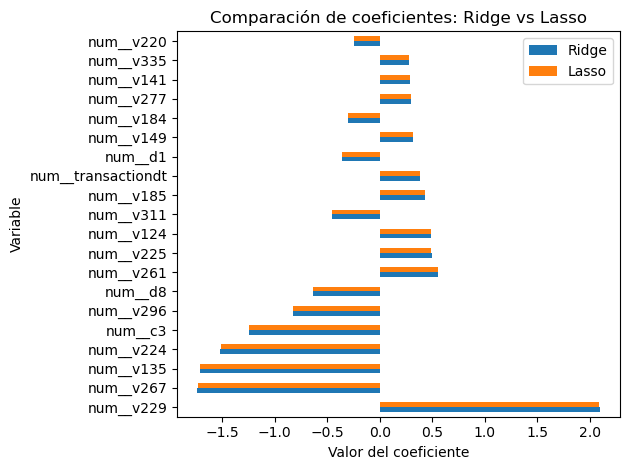

In [38]:
import pandas as pd
import numpy as np

# Obtener nombres de las variables
feature_names = X.columns

# Extraer coeficientes
ridge_coefs = best_ridge_model.coef_[0]
lasso_coefs = best_lasso_model.coef_[0]

# Crear DataFrame comparativo
coef_df = pd.DataFrame({
    'Variable': feature_names,
    'Ridge': ridge_coefs,
    'Lasso': lasso_coefs
})

# Ordenar por valor absoluto en Ridge para ver las más importantes
coef_df['Abs(Ridge)'] = np.abs(coef_df['Ridge'])
coef_df = coef_df.sort_values(by='Abs(Ridge)', ascending=False).drop(columns='Abs(Ridge)')

# Mostrar tabla
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
coef_df.set_index('Variable')[['Ridge', 'Lasso']].head(20).plot(kind='barh')
plt.title("Comparación de coeficientes: Ridge vs Lasso")
plt.xlabel("Valor del coeficiente")
plt.tight_layout()
plt.show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_16808\1558321638.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


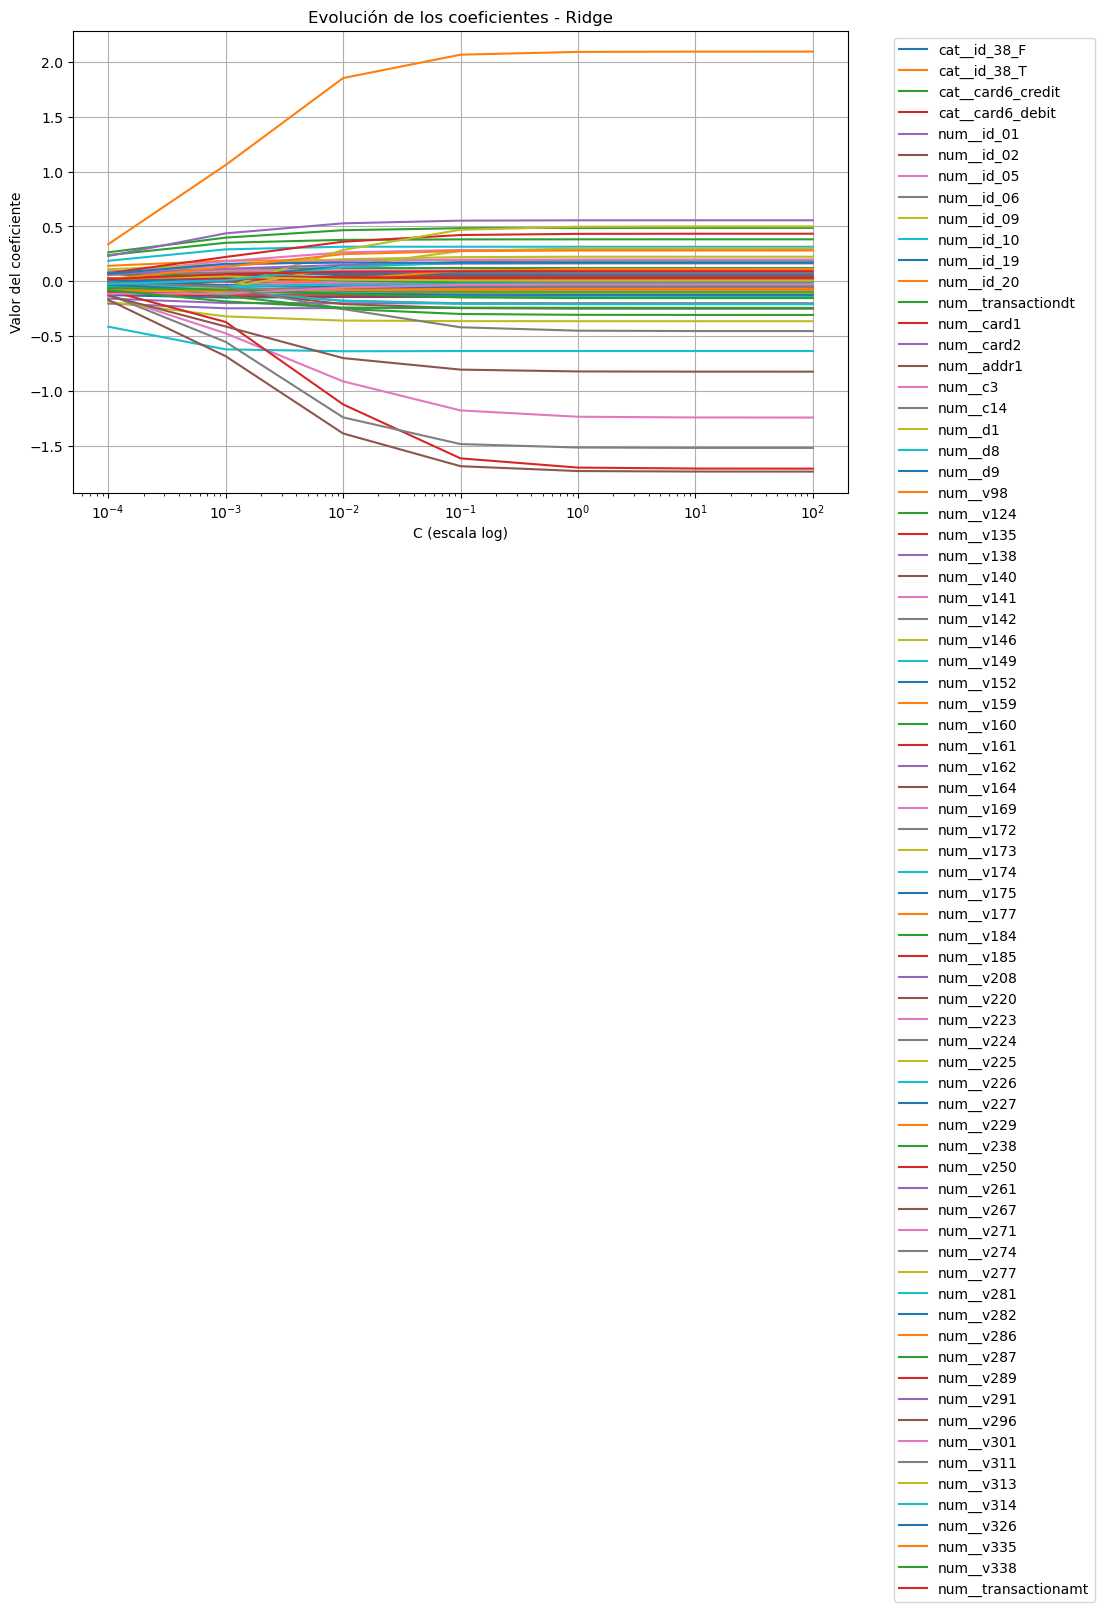

C:\Users\Asus\AppData\Local\Temp\ipykernel_16808\1558321638.py:49: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


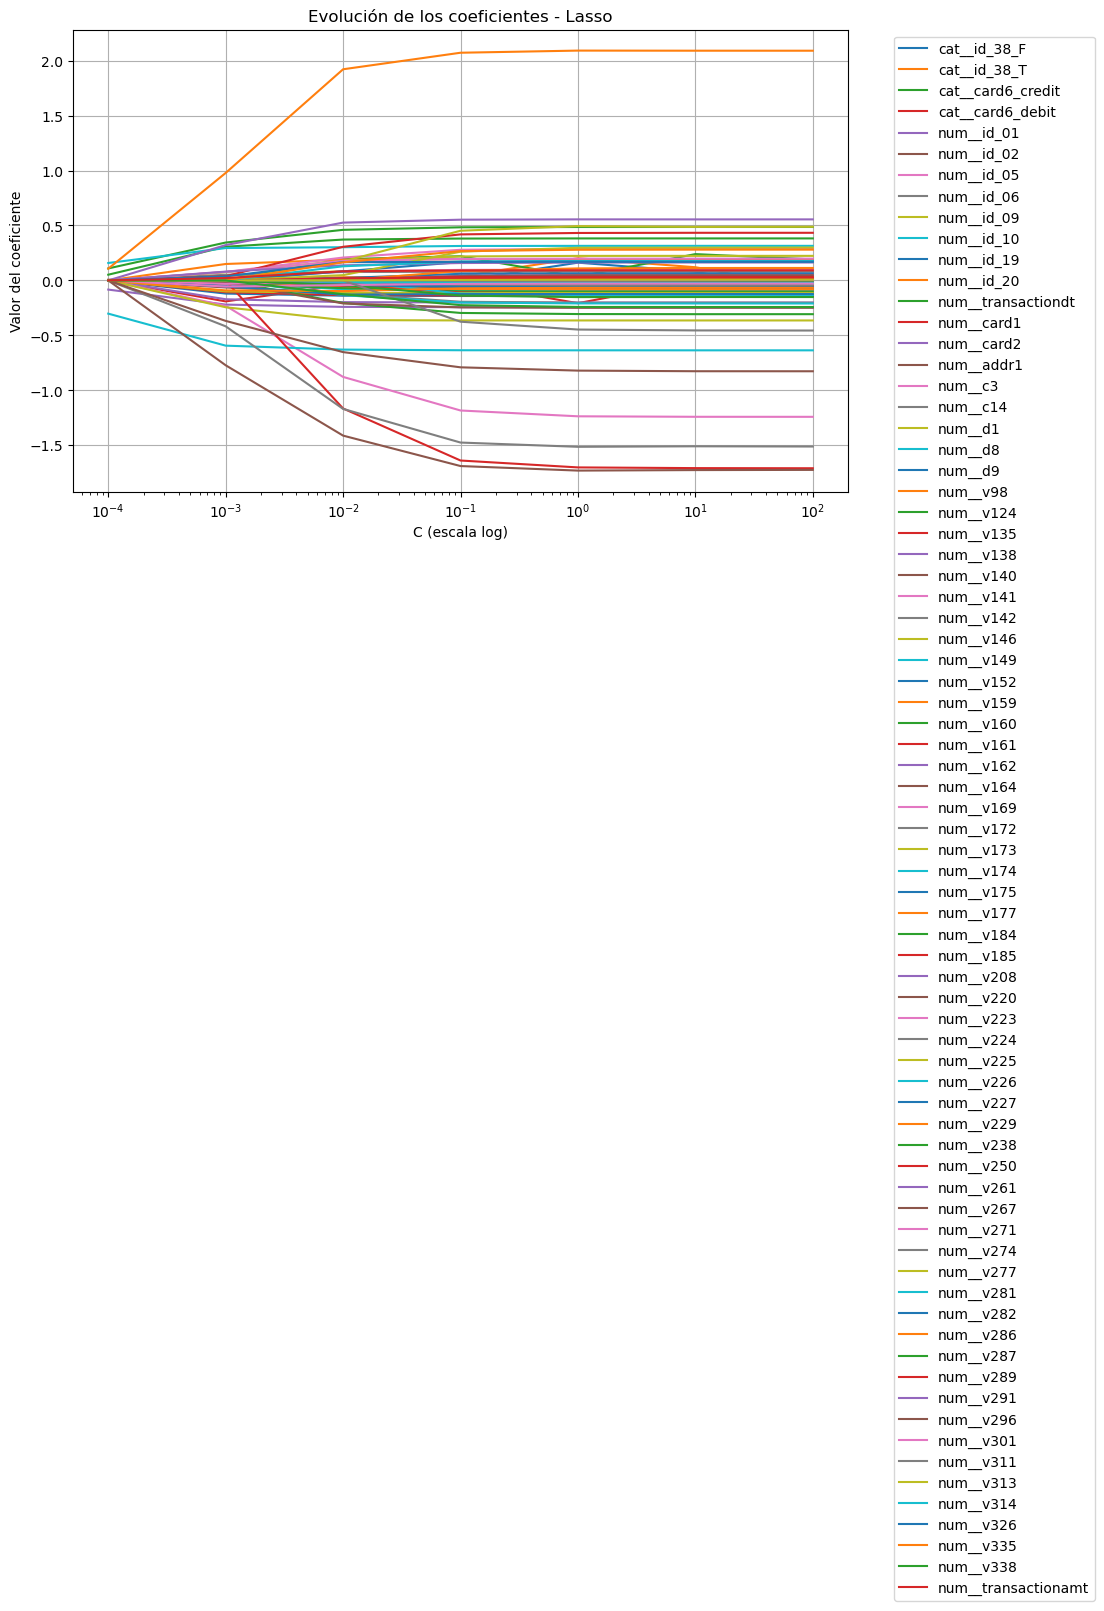

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# === Valores de C a explorar ===
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
feature_names = X.columns

ridge_coefs = []
lasso_coefs = []

for C in C_values:
    ridge = LogisticRegression(penalty='l2', solver='liblinear', C=C, max_iter=1000)
    lasso = LogisticRegression(penalty='l1', solver='liblinear', C=C, max_iter=1000)

    ridge.fit(X_train_bal, y_train_bal)
    lasso.fit(X_train_bal, y_train_bal)

    ridge_coefs.append(ridge.coef_[0])
    lasso_coefs.append(lasso.coef_[0])

# === Convertir a arrays para graficar ===
ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

# === Graficar coeficientes de Ridge ===
plt.figure(figsize=(10, 6))
for i in range(ridge_coefs.shape[1]):
    plt.plot(C_values, ridge_coefs[:, i], label=feature_names[i])
plt.xscale("log")
plt.title("Evolución de los coeficientes - Ridge")
plt.xlabel("C (escala log)")
plt.ylabel("Valor del coeficiente")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Graficar coeficientes de Lasso ===
plt.figure(figsize=(10, 6))
for i in range(lasso_coefs.shape[1]):
    plt.plot(C_values, lasso_coefs[:, i], label=feature_names[i])
plt.xscale("log")
plt.title("Evolución de los coeficientes - Lasso")
plt.xlabel("C (escala log)")
plt.ylabel("Valor del coeficiente")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
# Contar cuántos coeficientes son exactamente cero en Lasso
zeros_lasso = np.sum(lasso_coefs == 0)
print(f"Número de coeficientes nulos en Lasso: {zeros_lasso}")


Número de coeficientes nulos en Lasso: 0


#### **Optimización del modelo con Saga**

In [38]:
# Importar librerías necesarias 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Separar variables predictoras y objetivo
X = fraude_train.drop(columns=['isfraud'])
y = fraude_train['isfraud']

# Dividir en entrenamiento y prueba (estratificado) 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Escalar los datos 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar RandomOverSampler SOLO en entrenamient
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train_scaled, y_train)

# Verificar distribución balanceada 
from collections import Counter
print("Distribución después del balanceo:", Counter(y_train_bal))

Distribución después del balanceo: Counter({0.0: 92992, 1.0: 92992})


In [39]:
# === 1. Importar librerías necesarias ===
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score

# === 2. Validación cruzada estratificada ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 3. Métrica: AUC ===
scorer = make_scorer(roc_auc_score, response_method="predict_proba")

# === 4. Modelo base Lasso (penalización L1) ===
lasso_model = LogisticRegression(
    penalty='l1',
    solver='saga',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)
# === 5. Grilla de hiperparámetros (explorada en escala logarítmica) ===
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

# === 6. Configurar GridSearchCV para Lasso ===
grid_search_lasso = GridSearchCV(
    estimator=lasso_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)
# === 7. Entrenamiento con búsqueda de hiperparámetros ===
grid_search_lasso.fit(X_train_bal, y_train_bal)

# === 8. Mostrar mejores parámetros y AUC ===
print("Mejor C:", grid_search_lasso.best_params_)
print("Mejor AUC promedio en validación cruzada:", grid_search_lasso.best_score_)



Fitting 5 folds for each of 7 candidates, totalling 35 fits
Mejor C: {'C': 100}
Mejor AUC promedio en validación cruzada: 0.8422470937792891


In [40]:
# === Entrenamiento final con mejor modelo Lasso ===
best_lasso_model = grid_search_lasso.best_estimator_

import time
start_time = time.time()
best_lasso_model.fit(X_train_bal, y_train_bal)
y_pred = best_lasso_model.predict(X_test_scaled)
y_proba = best_lasso_model.predict_proba(X_test_scaled)[:, 1]
end_time = time.time()

print(f"\nTiempo de cómputo (Lasso): {end_time - start_time:.4f} segundos")

# === Reporte de clasificación ===
from sklearn.metrics import classification_report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))


Tiempo de cómputo (Lasso): 175.0928 segundos

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.97      0.81      0.88     39871
         1.0       0.24      0.70      0.36      3395

    accuracy                           0.80     43266
   macro avg       0.60      0.76      0.62     43266
weighted avg       0.91      0.80      0.84     43266



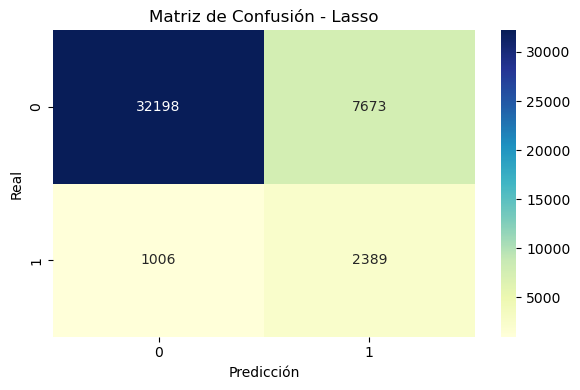

In [41]:
# === Matriz de confusión ===
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - Lasso")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


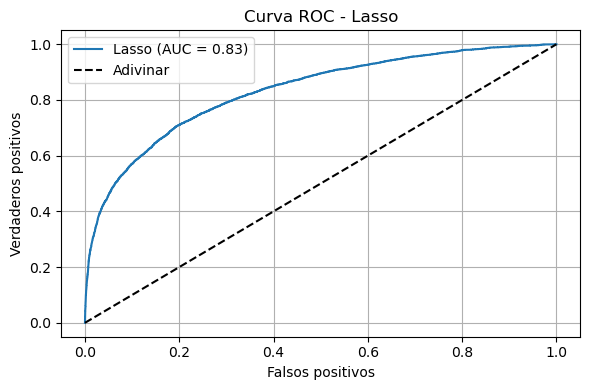

In [42]:
# === Curva ROC y AUC ===
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Lasso (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - Lasso")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### **Random Forest**

In [51]:
# === 1. Importar librerías necesarias ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# === 2. Separar variables predictoras y objetivo ===
X = fraude_train.drop(columns=['isfraud'])
y = fraude_train['isfraud']

# === 3. Dividir en entrenamiento y prueba (estratificado) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === 4. Escalar los datos ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Aplicar RandomOverSampler SOLO en entrenamiento ===
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train_scaled, y_train)

# === 6. Verificar distribución balanceada ===
from collections import Counter
print("Distribución después del balanceo:", Counter(y_train_bal))

Distribución después del balanceo: Counter({0.0: 92992, 1.0: 92992})


In [52]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}


In [54]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Métrica: AUC
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Modelo base
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Configuración del GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)
# === Entrenamiento con búsqueda de hiperparámetros ===
grid_search_rf.fit(X_train_bal, y_train_bal)
# === Mostrar resultados ===
print("Mejores hiperparámetros:", grid_search_rf.best_params_)
print("Mejor AUC promedio en validación cruzada:", grid_search_rf.best_score_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor AUC promedio en validación cruzada: 0.9976382826617352


In [55]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import time

# === Entrenamiento final con el mejor modelo ===
best_rf_model = grid_search_rf.best_estimator_

start_time = time.time()
best_rf_model.fit(X_train_bal, y_train_bal)
y_pred = best_rf_model.predict(X_test_scaled)
y_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]
end_time = time.time()

print(f"\nTiempo de cómputo (Random Forest): {end_time - start_time:.4f} segundos")

# === Reporte de clasificación ===
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))



Tiempo de cómputo (Random Forest): 11.6339 segundos

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     39871
         1.0       0.82      0.60      0.69      3395

    accuracy                           0.96     43266
   macro avg       0.89      0.79      0.84     43266
weighted avg       0.96      0.96      0.96     43266



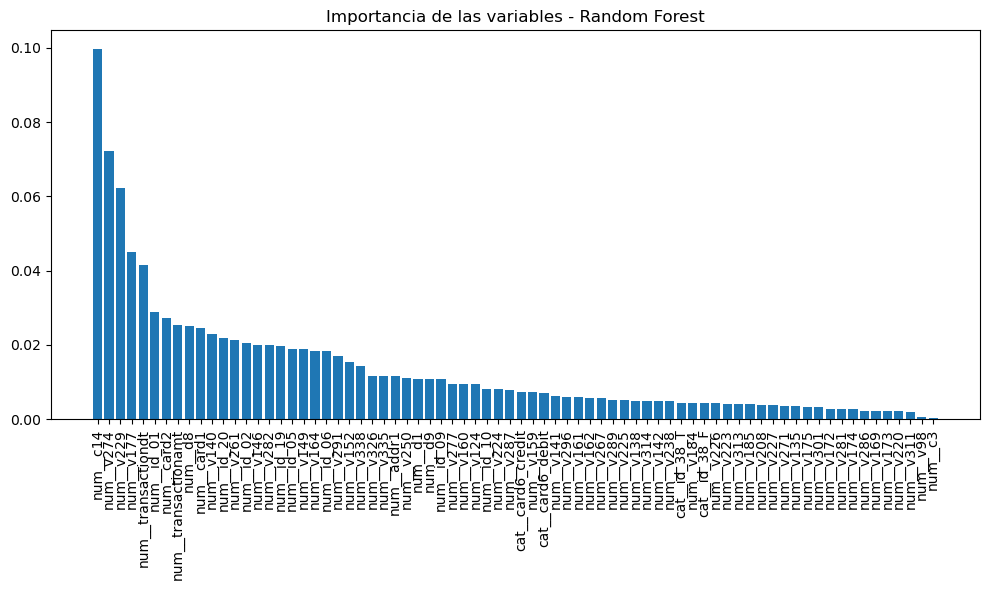

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Obtener nombres de columnas
feature_names = X.columns  

# Obtener importancias desde el mejor modelo
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # De mayor a menor

# Visualización
plt.figure(figsize=(10,6))
plt.title("Importancia de las variables - Random Forest")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


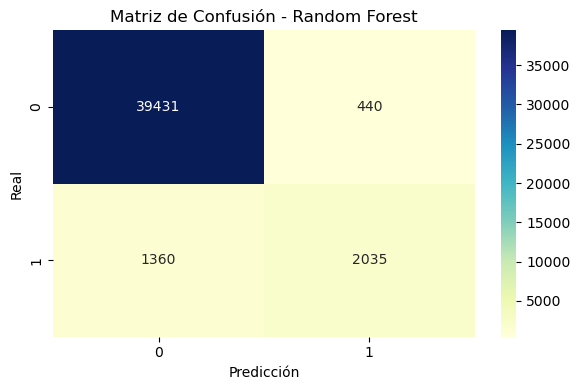

In [57]:

# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


AUC final sobre test: 0.9398


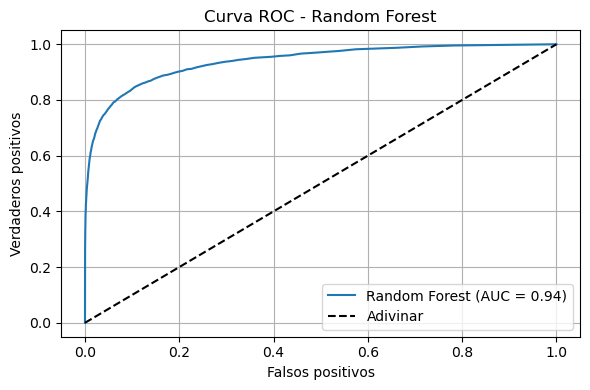

In [58]:

# === Curva ROC y AUC ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
print(f"\nAUC final sobre test: {auc_score:.4f}")

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - Random Forest")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
# === 1. Importar librerías ===
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

# === 2. Definir validación cruzada y métrica AUC ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(roc_auc_score, needs_proba=True)

# === 3. Modelo base de Random Forest ===
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)


### **XGBOOST**

In [13]:
# === 1. Importar librerías necesarias ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# === 2. Separar variables predictoras y objetivo ===
X = fraude_train.drop(columns=['isfraud'])
y = fraude_train['isfraud']

# === 3. Dividir en entrenamiento y prueba (estratificado) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === 4. Escalar los datos ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Aplicar RandomOverSampler SOLO en entrenamiento ===
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train_scaled, y_train)

# === 6. Verificar distribución balanceada ===
from collections import Counter
print("Distribución después del balanceo:", Counter(y_train_bal))

Distribución después del balanceo: Counter({0.0: 92992, 1.0: 92992})


In [14]:
# === 1. Importar librerías ===
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score

# === 2. Definir espacio de búsqueda ===
param_grid = {
    'n_estimators': [100, 200,300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# === 3. Validación cruzada estratificada ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 4. Métrica: AUC ===
scorer = make_scorer(roc_auc_score, response_method="predict_proba")

# === 5. Modelo base ===
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1)

# === 6. Configuración del GridSearchCV ===
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)
# === 7. Entrenamiento con búsqueda de hiperparámetros ===
grid_search_xgb.fit(X_train_bal, y_train_bal)

# === 8. Mostrar resultados ===
print("Mejores hiperparámetros:", grid_search_xgb.best_params_)
print("Mejor AUC promedio en validación cruzada:", grid_search_xgb.best_score_)




Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiperparámetros: {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Mejor AUC promedio en validación cruzada: 0.9973081035295006


In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import time

# === Entrenamiento final con los mejores parámetros ===
best_xgb_model = grid_search_xgb.best_estimator_

start_time = time.time()
best_xgb_model.fit(X_train_bal, y_train_bal)
y_pred = best_xgb_model.predict(X_test_scaled)
y_proba = best_xgb_model.predict_proba(X_test_scaled)[:, 1]
end_time = time.time()

print(f"\nTiempo de cómputo (XGBoost): {end_time - start_time:.4f} segundos")

# === Reporte de clasificación ===
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))



Tiempo de cómputo (XGBoost): 3.3409 segundos

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     39871
         1.0       0.87      0.66      0.75      3395

    accuracy                           0.97     43266
   macro avg       0.92      0.83      0.86     43266
weighted avg       0.96      0.97      0.96     43266



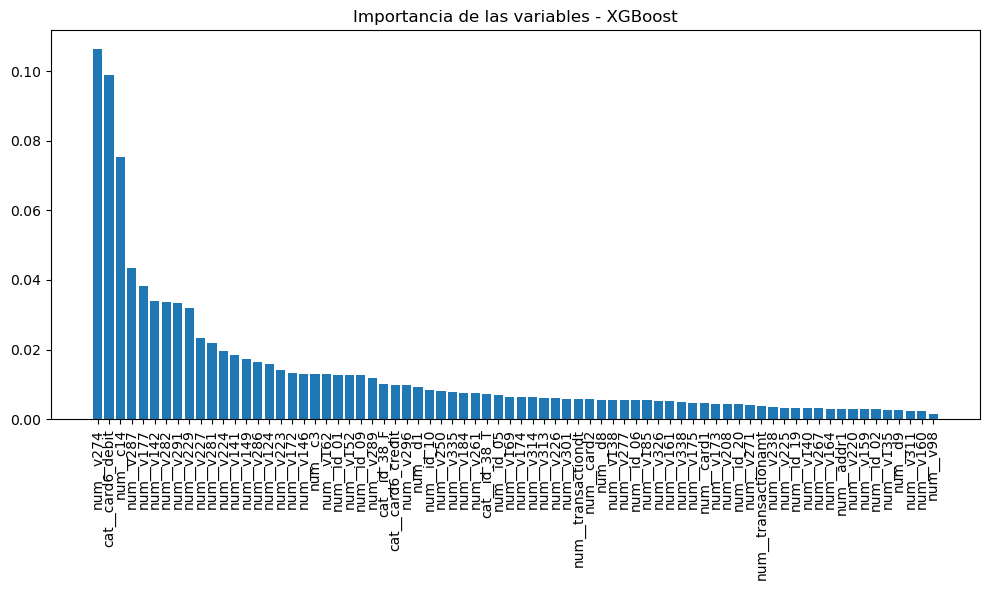

In [18]:
import numpy as np
import pandas as pd

# === Importancia de variables ===
importances = best_xgb_model.feature_importances_
feature_names = X.columns  # Usa X original sin escalar
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Importancia de las variables - XGBoost")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


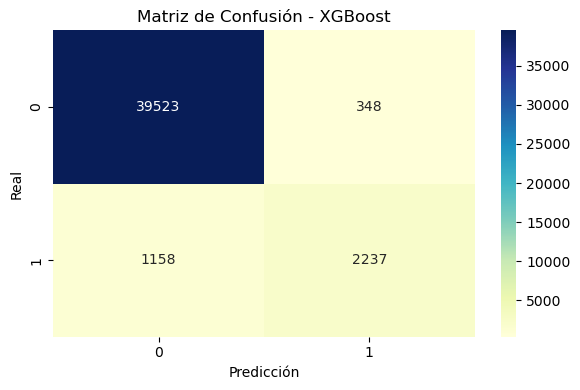

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - XGBoost")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()



AUC final sobre test: 0.9586


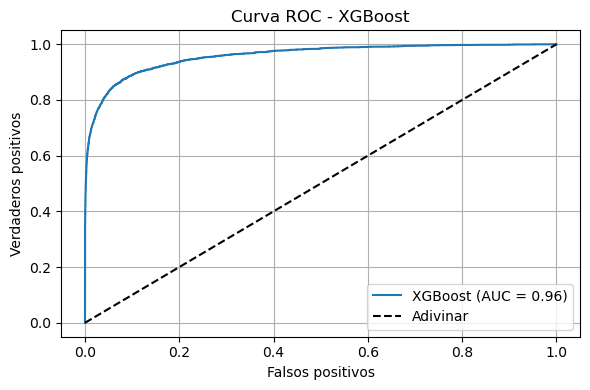

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# === Curva ROC y AUC ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
print(f"\nAUC final sobre test: {auc_score:.4f}")

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - XGBoost")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


#### **Optimización del modelo con `tree_method='hist'`**

In [12]:
# === 1. Importar librerías necesarias ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# === 2. Separar variables predictoras y objetivo ===
X = fraude_train.drop(columns=['isfraud'])
y = fraude_train['isfraud']

# === 3. Dividir en entrenamiento y prueba (estratificado) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === 4. Escalar los datos ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Aplicar RandomOverSampler SOLO en entrenamiento ===
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train_scaled, y_train)

# === 6. Verificar distribución balanceada ===
from collections import Counter
print("Distribución después del balanceo:", Counter(y_train_bal))

Distribución después del balanceo: Counter({0.0: 92992, 1.0: 92992})


In [19]:
# === Dividir validación interna para early stopping ===
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import time


X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_bal, y_train_bal, test_size=0.2, stratify=y_train_bal, random_state=42
)

# === Mejor modelo optimizado manualmente ===
xgb_opt = XGBClassifier(
    n_estimators=300,               
    learning_rate=0.1,
    subsample=1,
    colsample_bytree=1,
    tree_method='hist',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

"""
# === Entrenamiento con early stopping ===
start_time = time.time()
xgb_opt.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val_sub, y_val_sub)],
    early_stopping_rounds=10,
    verbose=False
)
end_time = time.time()
"""

# === Entrenamiento sin early stopping ===
start_time = time.time()
xgb_opt.fit(X_train_bal, y_train_bal)
end_time = time.time()


# === Predicción ===
y_pred_xgb = xgb_opt.predict(X_test_scaled)
y_proba_xgb = xgb_opt.predict_proba(X_test_scaled)[:, 1]

print(f"\nTiempo de cómputo (XGBoost optimizado): {end_time - start_time:.4f} segundos")

# === Reporte de clasificación ===
print("\n=== Classification Report (XGBoost optimizado) ===")
print(classification_report(y_test, y_pred_xgb))



Tiempo de cómputo (XGBoost optimizado): 2.2541 segundos

=== Classification Report (XGBoost optimizado) ===
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     39871
         1.0       0.78      0.62      0.69      3395

    accuracy                           0.96     43266
   macro avg       0.88      0.80      0.83     43266
weighted avg       0.95      0.96      0.95     43266



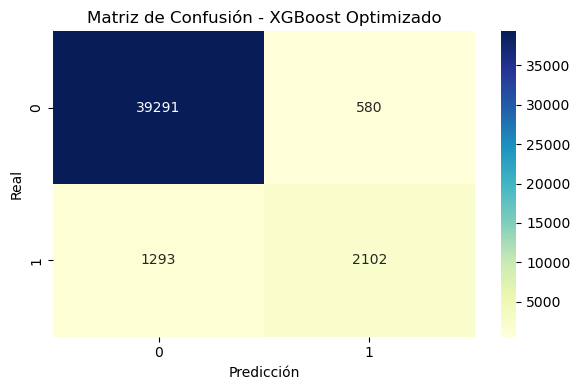

In [20]:
# === Matriz de confusión ===
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - XGBoost Optimizado")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()



AUC final sobre test: 0.9456


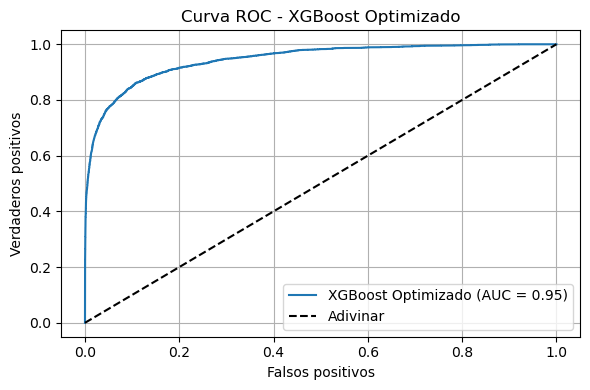

In [21]:
# === Curva ROC y AUC ===
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
auc_score = roc_auc_score(y_test, y_proba_xgb)
print(f"\nAUC final sobre test: {auc_score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'XGBoost Optimizado (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - XGBoost Optimizado")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### **SVM (Máquina de soprte vectorial)**

In [46]:
# === 1. Importar librerías necesarias ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# === 2. Separar variables predictoras y objetivo ===
X = fraude_train.drop(columns=['isfraud'])
y = fraude_train['isfraud']

# === 3. Dividir en entrenamiento y prueba (estratificado) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === 4. Escalar los datos ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Aplicar RandomOverSampler SOLO en entrenamiento ===
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train_scaled, y_train)

# === 6. Verificar distribución balanceada ===
from collections import Counter
print("Distribución después del balanceo:", Counter(y_train_bal))

Distribución después del balanceo: Counter({0.0: 92992, 1.0: 92992})


In [ ]:
# === 1. Importar librerías ===
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

# === 2. Configurar validación cruzada y métrica ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(roc_auc_score, needs_proba=True)

# === 3. Definir modelo base SVC (kernel lineal) ===
svc_base = SVC(kernel='linear', probability=True, random_state=42)

# === 4. Calibrar el modelo ===
svc_calibrado = CalibratedClassifierCV(estimator=svc_base, cv=3)

# === 5. Grilla de hiperparámetros (parámetro C) ===
param_grid = {'estimator__C': [0.01, 0.1, 1, 10, 100]}

# === 6. Configurar GridSearchCV ===
grid_search_svc = GridSearchCV(
    estimator=svc_calibrado,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# === 7. Ejecutar búsqueda en datos balanceados ===
grid_search_svc.fit(X_train_bal, y_train_bal)

# === 8. Resultados ===
print("Mejor C:", grid_search_svc.best_params_['estimator__C'])
print("Mejor AUC promedio en validación cruzada:", grid_search_svc.best_score_)


In [ ]:
# Evaluación final
from sklearn.metrics import classification_report
import time

svc_final = grid_search_svc.best_estimator_

start_time = time.time()
svc_final.fit(X_train_bal, y_train_bal)
y_pred = svc_final.predict(X_test_scaled)
y_proba = svc_final.predict_proba(X_test_scaled)[:, 1]
end_time = time.time()

print(f"\nTiempo de cómputo (SVC kernel='linear'): {end_time - start_time:.4f} segundos")

# === Reporte de clasificación ===
print("\n=== Classification Report (SVC kernel='linear') ===")
print(classification_report(y_test, y_pred))


#### **Optimización del modelo con LinearSVC**

In [47]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

# Definir el grid para C (usando la notación de GridSearchCV para el estimador encapsulado)
param_grid = {'estimator__C': [0.01, 0.1, 1, 10, 100]}

# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Definir el modelo base
base_svm = LinearSVC(max_iter=10000, random_state=42)
# Calibrar el modelo
svm_calibrado = CalibratedClassifierCV(estimator=base_svm, cv=3)

# Configurar GridSearchCV con el modelo calibrado y el grid de hiperparámetros
grid_search = GridSearchCV(
    estimator=svm_calibrado,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1
)

# Ejecutar GridSearchCV con los datos balanceados
grid_search.fit(X_train_bal, y_train_bal)

# Mostrar resultados
print("Mejor C:", grid_search.best_params_['estimator__C'])
print("Mejor AUC promedio en validación cruzada:", grid_search.best_score_)



c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Mejor C: 100
Mejor AUC promedio en validación cruzada: 0.841249375832151


In [48]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

# === Entrenamiento final con el mejor modelo encontrado ===
svm_final = grid_search.best_estimator_

# === Medir tiempo de entrenamiento y predicción ===
start_time = time.time()
svm_final.fit(X_train_bal, y_train_bal)  
y_pred = svm_final.predict(X_test_scaled)
y_proba = svm_final.predict_proba(X_test_scaled)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Tiempo de cómputo (SVM calibrado): {elapsed_time:.4f} segundos")

# === Reporte de clasificación ===
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))


Tiempo de cómputo (SVM calibrado): 11.4271 segundos

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.97      0.80      0.88     39871
         1.0       0.23      0.71      0.35      3395

    accuracy                           0.79     43266
   macro avg       0.60      0.75      0.61     43266
weighted avg       0.91      0.79      0.83     43266



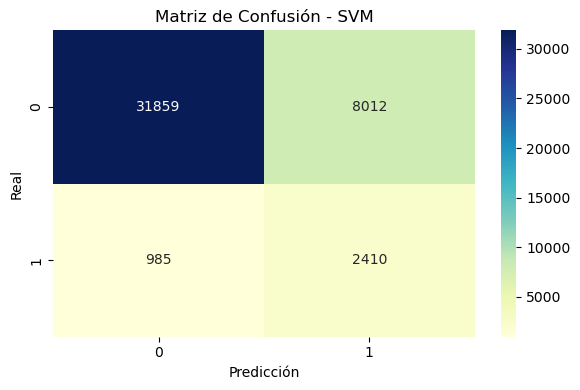

In [49]:

# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Matriz de Confusión - SVM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()



AUC final sobre test: 0.8312


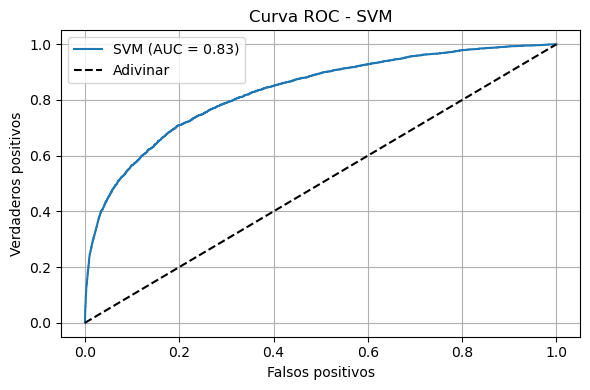

In [50]:

# === Curva ROC y AUC ===
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
auc_score = roc_auc_score(y_test, y_proba[:, 1])
print(f"\nAUC final sobre test: {auc_score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'SVM (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - SVM")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


#### **Optimización del modelo con SGD SVM (SGDClassifier)**